# Clustering News Articles

Previously, we performed data mining knowing what we were looking for. Our use of target classes allowed us to learn how our variables model those targets during the training phase. This type of learning, where we have targets to train against, is called **supervised learning**. Here, we consider what we do without those targets. This is **unsupervised learning** and is much more of an exploratory task. Rather than wanting to classify with our model, the goal in unsupervised learning is more about exploring the data to find insights.

We will look at clustering news articles to find trends and patterns in the data. We look at how we can extract data from different websites using a link aggregation website to show a variety of news stories.

The key concepts covered in this chapter include:
- Obtaining text from arbitrary websites
- Using the reddit API to collect interesting news stories
- Cluster analysis for unsupervised data mining
- Extracting topics from documents
- Online learning for updating a model without retraining it
- Cluster ensembling to combine different models

## Obtaining news articles

We will build a system that takes a news articles and groups them together, where the groups have similar topics. Our goal is to generate fake news articles in python and then cluster them to
see any major themes or concepts that occur.

## Generate news articles

In [1]:
import faker
import random
from datetime import datetime, timedelta

In [2]:
fake = faker.Faker()

## Create articles with indicators

We will create fake articles with indicators, i.e. a string of words that only occur in a select few articles. Idealy we will create 6 clusters with 6 indicators that is a sample of 3 words from a list of popular words. In our case we use the words:

```
danish,cheesecake,sugar,
Lollipop,wafer,Gummies,
sesame,Jelly,beans,
pie,bar,Ice,oat 
```

**Note**: Indicators are a simple way of creating trivial clusters. This is for learning purposes and in real life it is hard to find these indicator and may not exist.

In [3]:
random.seed(42)

sample_size = 3
num_of_iters = 6
samples = []

my_word_list = [
    'danish','cheesecake','sugar',
    'Lollipop','wafer','Gummies',
    'sesame','Jelly','beans',
    'pie','bar','Ice','oat' ]

for _ in range(num_of_iters):
    random_sample = random.sample(my_word_list, sample_size)
    samples.append(random_sample)

for i, sample in enumerate(samples):
    print(f"Indicator {i} {sample}:")


Indicator 0 ['bar', 'cheesecake', 'danish']:
Indicator 1 ['Ice', 'wafer', 'Lollipop']:
Indicator 2 ['Lollipop', 'sugar', 'cheesecake']:
Indicator 3 ['bar', 'Ice', 'beans']:
Indicator 4 ['cheesecake', 'pie', 'sesame']:
Indicator 5 ['danish', 'oat', 'cheesecake']:


In [4]:
def generate_title():
    max_words = 5  # Maximum number of words
    num_words = random.randint(1, max_words)
    return ' '.join(fake.word() for _ in range(num_words))

def generate_author():
    return f"{fake.first_name()} {fake.last_name()}"

def generate_content(sample, num_indicators=1):
    lines = []
    for _ in range(300):
        lines.append(fake.text())
    # here is where we insert the indicators in the fake article
    for _ in range(num_indicators):
        lines.append(fake.sentence(ext_word_list=sample))
    
    random.shuffle(lines)
    text = '/n'.join(lines)

    return text

In [5]:
def generate_article(samples, num_indicators=1):
    docs = []
    for sample in samples:

        title = generate_title()
        author = generate_author()
        content = generate_content(sample, num_indicators)

        article = f"""
        Title: {title}
        Author: {author}
        {content}
        """
        docs.append(article)

    return docs

def return_docs(return_docs=60, num_indicators=1):
    dcuments = []
    for _ in range(return_docs):
        # this should return 6 articles with 6 indicators
        dcuments += generate_article(samples, num_indicators)
    # this should return 6*60=360 (by default) articles with 6 indicators
    return dcuments

In [6]:
documents = return_docs(num_indicators=10)
print(len(documents))

360


In [7]:
print(documents[0][:400])


        Title: fear I
        Author: Mark Hicks
        Author beautiful huge little develop specific along plant. Usually woman stay kind.
Mention cultural risk college mission dream also. Million certain beat firm well wish throughout./nStart fast among risk college.
Area well seven source among ten why. Table though window statement./nNational under along after. Though white six responsibilit


## Grouping news articles

The aim is to discover trends in news articles by clustering, or grouping, them together. To do that, we will use the k-means algorithm, a classic machine-learning algorithm originally developed in 1957.

Clustering is an unsupervised learning technique and we use clustering algorithms for exploring data. Our dataset contains approximately 360 stories, and it would be quite arduous to examine each of those stories individually. Even if we used summary statistics, that is still a lot of data. Using clustering allows us to group similar stories together, and we can explore the themes in each cluster independently.

We use clustering techniques when we don't have a clear set of target classes for our data. In that sense, clustering algorithms have little direction in their learning. They learn according to some function, regardless of the underlying meaning of the data. For this reason, it is critical to choose good features. In supervised learning, if you choose poor features, the learning algorithm can choose to not use those features. For instance, support vector machines will give little weight to features that aren't useful in classification. However, with clustering, all features are used in the final result—even if those features don't provide us with the answer we were looking for.

When performing cluster analysis on real-world data, it is always a good idea to have a sense of what sorts of features will work for your scenario. We will use the bag-of-words model. We are looking for topic-based groups, so we will use topic-based features to model the documents. We know those features work because of the work others have done in supervised versions of our problem. In contrast, if we were to perform an authorship-based clustering, we would use features such as those found in 9, Authorship Attribution experiment.

## The k-means algorithm

The k-means clustering algorithm finds **centroids** that best represent the data using an iterative process. The algorithm starts with a predefined set of centroids, which are normally data points taken from the training data. The $k$ in k-means is the number of centroids to look for and how many clusters the algorithm will find. For instance, setting k to 3 will find three clusters in the dataset.

There are two phases to the k-means: assignment and updating.

- First, we set a label to every sample in the dataset linking it to the nearest centroid. 
    - For each sample nearest to centroid 1, we assign the label 1. 
    - For each sample nearest to centroid 2, we assign a label 2 and so on for each of the k centroids. 
    - We say that each data point with the label 1 is in cluster 1 (at this time only, as assignments can change as the algorithm runs).
- In the updating step, we take each of the clusters and compute the centroid, which is the mean of all of the samples in that cluster.

The algorithm then iterates between the assignment step and the updating step; each time the updating step occurs, each of the centroids moves a small amount. This causes the assignments to change slightly, causing the centroids to move a small amount in
the next iteration. This repeats until some stopping criterion is reached. It is common to stop after a certain number of iterations, or when the total movement of the centroids is very low. The algorithm can also complete in some scenarios, which means that the
clusters are stable—the assignments do not change and neither do the centroids.

The k-means algorithm is fascinating for its mathematical properties and historical significance. It is an algorithm that (roughly) only has a single parameter, and is quite effective and frequently used, even more than 50 years after its discovery.

There is a k-means algorithm in scikit-learn, which we import from the cluster
subpackage:

In [8]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [9]:
from sklearn.pipeline import Pipeline

n_clusters = 10
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))])


## Evaluating the results

Clustering is mainly an exploratory analysis, and therefore it is difficult to evaluate a clustering algorithm's results effectively. A straightforward way is to evaluate the algorithm based on the criteria the algorithm tries to learn from.

In the case of the k-means algorithm, the criterion that it uses when developing the centroids is to minimize the distance from each sample to its nearest centroid. This is called the **inertia** of the algorithm and can be retrieved from any KMeans instance that has had fit called on it:

In [10]:
pipeline.fit(documents)
labels = pipeline.predict(documents)

from collections import Counter
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 60 samples
Cluster 1 contains 48 samples
Cluster 2 contains 29 samples
Cluster 3 contains 41 samples
Cluster 4 contains 60 samples
Cluster 5 contains 4 samples
Cluster 6 contains 12 samples
Cluster 7 contains 31 samples
Cluster 8 contains 56 samples
Cluster 9 contains 19 samples


In [11]:
c[0]

60

In [12]:
pipeline.named_steps['clusterer'].inertia_

127.39709236494782

Unfortunately, this value is quite meaningless by itself, but we can use it to determine how many clusters we should use. In
the preceding example, we set `n_clusters` to 10, but is this the best value? The following code runs the k-means algorithm 10 times with each value of n_clusters from 2 to 15. For each run, it records the inertia of the result. 

In [13]:
import numpy as np

inertia_scores = []
n_cluster_values = list(range(2, 15))
for n_clusters in n_cluster_values:
    print(f'starting n_clusster: {n_clusters}')
    cur_inertia_scores = []
    X = TfidfVectorizer(max_df=0.4).fit_transform(documents)
    for i in range(30):
        if (i%15 == 0) & (i > 0):
            print(f'finished {i}/30')
        km = KMeans(n_clusters=n_clusters).fit(X)
        cur_inertia_scores.append(km.inertia_)
    inertia_scores.append(cur_inertia_scores)
inertia_scores = np.array(inertia_scores)

starting n_clusster: 2
finished 15/30
starting n_clusster: 3
finished 15/30
starting n_clusster: 4
finished 15/30
starting n_clusster: 5
finished 15/30
starting n_clusster: 6
finished 15/30
starting n_clusster: 7
finished 15/30
starting n_clusster: 8
finished 15/30
starting n_clusster: 9
finished 15/30
starting n_clusster: 10
finished 15/30
starting n_clusster: 11
finished 15/30
starting n_clusster: 12
finished 15/30
starting n_clusster: 13
finished 15/30
starting n_clusster: 14
finished 15/30


The `inertia_scores` variable now contains a list of inertia scores for each `n_clusters` value between 2 and 15. We can plot this to get a sense of how this value interacts with n_clusters:

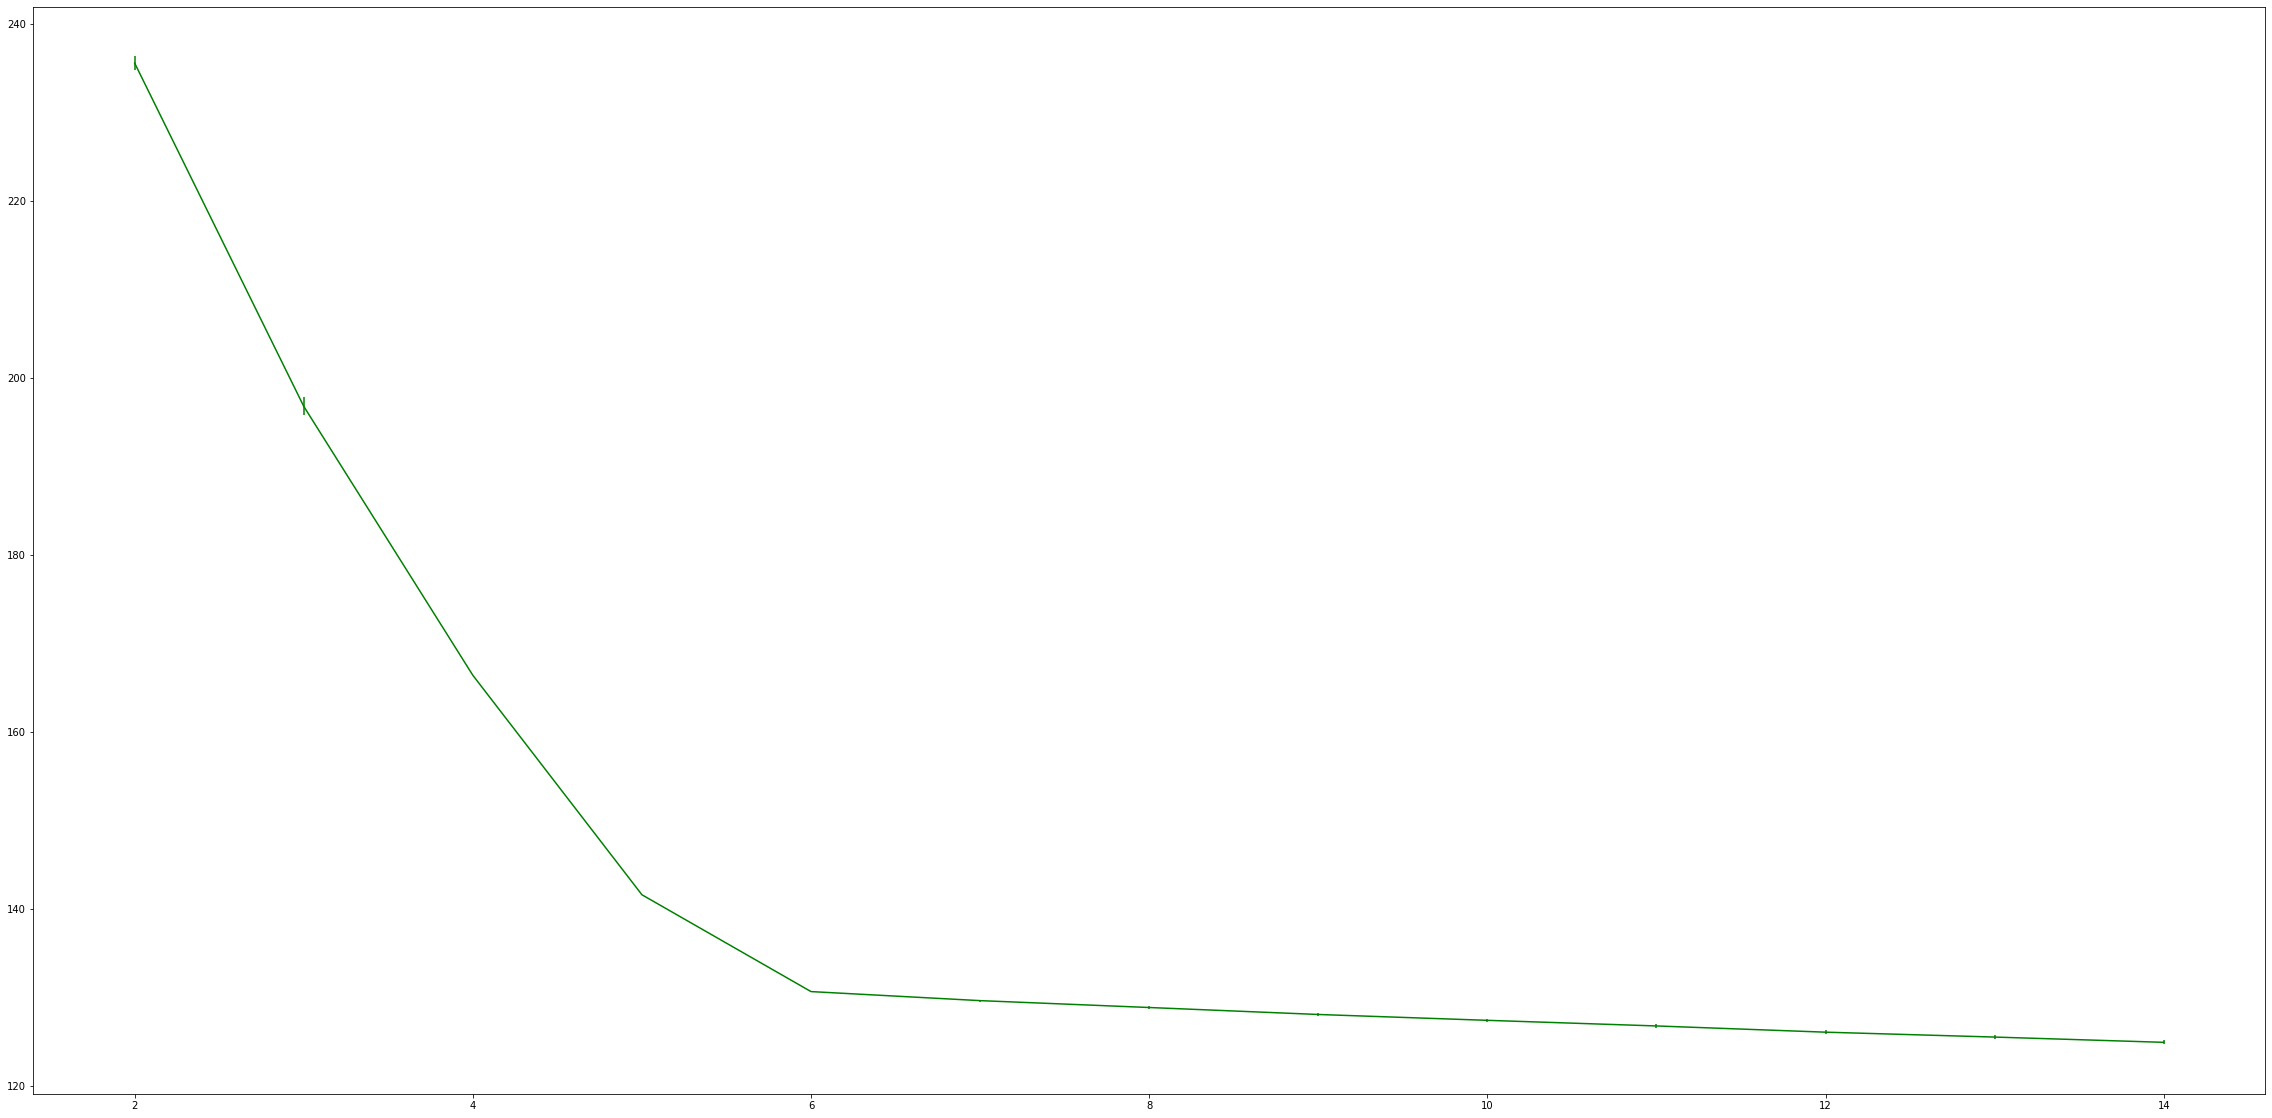

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

inertia_means = np.mean(inertia_scores, axis=1)
inertia_stderr = np.std(inertia_scores, axis=1)

fig = plt.figure(figsize=(40,20))
plt.errorbar(n_cluster_values, inertia_means, inertia_stderr, color='green')
plt.show()

Overall, the value of the inertia should decrease with reducing improvement as the number of clusters improves, which we can broadly see from these results. The increase between values of 6 to 7 is due only to the randomness in selecting the centroids, which directly affect how good the final results are. Despite this, there is a general trend (in these results; your results may vary) that about 6 clusters is the last time a major improvement in the inertia occurred. 

After this point, only slight improvements are made to the inertia, although it is hard to be specific about vague criteria such as this. Looking for this type of pattern is called the elbow rule, in that we are looking for an elbow-esque bend in the graph. Some datasets have more pronounced elbows, but this feature isn't guaranteed to even appear (some graphs may be smooth!). Based on this analysis, we set n_clusters to be 6 and then rerun the algorithm:

In [15]:
n_clusters = 6

pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))
                     ])
pipeline.fit(documents)

Pipeline(steps=[('feature_extraction', TfidfVectorizer(max_df=0.4)),
                ('clusterer', KMeans(n_clusters=6))])

In [16]:
labels = pipeline.predict(documents)

## Extracting topic information from clusters

Now we set our sights on the clusters in an attempt to discover the topics in each. We first extract the term list from our feature extraction step:

In [18]:

c = Counter(labels)

terms = pipeline.named_steps['feature_extraction'].get_feature_names_out()

for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))
    print("  Most important terms")
    centroid = pipeline.named_steps['clusterer'].cluster_centers_[cluster_number]
    most_important = centroid.argsort()
    for i in range(5):
        term_index = most_important[-(i+1)]
        print("  {0}) {1} (score: {2:.4f})".format(i+1, terms[term_index], centroid[term_index]))
    print()

Cluster 0 contains 60 samples
  Most important terms
  1) danish (score: 0.5455)
  2) ndanish (score: 0.1222)
  3) nstandard (score: 0.0222)
  4) npretty (score: 0.0213)
  5) nnear (score: 0.0209)

Cluster 1 contains 60 samples
  Most important terms
  1) beans (score: 0.5807)
  2) ice (score: 0.4312)
  3) nbeans (score: 0.1307)
  4) nfull (score: 0.0169)
  5) nreligious (score: 0.0166)

Cluster 2 contains 60 samples
  Most important terms
  1) sesame (score: 0.5607)
  2) pie (score: 0.5147)
  3) npie (score: 0.1375)
  4) nsesame (score: 0.1171)
  5) ntrial (score: 0.0160)

Cluster 3 contains 60 samples
  Most important terms
  1) sugar (score: 0.5803)
  2) lollipop (score: 0.4247)
  3) nsugar (score: 0.1395)
  4) nlollipop (score: 0.0917)
  5) nbad (score: 0.0182)

Cluster 4 contains 60 samples
  Most important terms
  1) oat (score: 0.5631)
  2) danish (score: 0.4548)
  3) noat (score: 0.1342)
  4) ndanish (score: 0.0995)
  5) nwar (score: 0.0173)

Cluster 5 contains 60 samples
  Mos

The results can be quite indicative of current trends. In my results (March 2015),
the clusters correspond to health matters, Middle East tensions, Korean tensions,
and Russian affairs. These were the main topics frequenting news around this
time—although this has hardly changed for a number of years!

## Using clustering algorithms as transformers

As a side note, one interesting property about the k-means algorithm (and any
clustering algorithm) is that you can use it for feature reduction. There are many
methods to reduce the number of features (or create new features to embed the
dataset on), such as Principle Component Analysis, Latent Semantic Indexing, and
many others. One issue with many of these algorithms is that they often need lots
of computing power.

In the preceding example, the terms list had more than 14,000 entries in it—it is
quite a large dataset. Our k-means algorithm transformed these into just six clusters.
We can then create a dataset with a much lower number of features by taking the
distance to each centroid as a feature. The code is as follows:

To do this, we call the transform function on a KMeans instance. Our pipeline is fit
for this purpose, as it has a k-means instance at the end:

In [ ]:
for sample in samples:
    print(sample)

In [ ]:
from sklearn.metrics import silhouette_score
X = pipeline.named_steps['feature_extraction'].transform(documents)
silhouette_score(X, labels)

In [ ]:
len(terms)

In [ ]:
Y = pipeline.transform(documents) 

In [ ]:
km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(Y)

In [ ]:
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

In [ ]:
silhouette_score(Y, labels)

In [ ]:
Y.shape

## Clustering ensembles
In Chapter 3, Predicting Sports Winners with Decision Trees, we looked at a classification
ensemble using the random forest algorithm, which is an ensemble of many lowquality, tree-based classifiers. Ensembling can also be performed using clustering
algorithms. One of the key reasons for doing this is to smooth the results from many
runs of an algorithm. As we saw before, the results from running k-means are varied,
depending on the selection of the initial centroids. Variation can be reduced by
running the algorithm many times and then combining the results.

Ensembling also reduces the effects of choosing parameters on the final result.
Most clustering algorithms are quite sensitive to the parameter values chosen for
the algorithm. Choosing slightly different parameters results in different clusters.

## Evidence accumulation

As a basic ensemble, we can first cluster the data many times and record the labels
from each run. We then record how many times each pair of samples was clustered
together in a new matrix. This is the essence of the Evidence Accumulation
Clustering (EAC) algorithm.

EAC has two major steps. The first step is to cluster the data many times using
a lower-level clustering algorithm such as k-means and record the frequency
that samples were in the same cluster, in each iteration. This is stored in a
coassociation matrix. The second step is to perform a cluster analysis on the
resulting coassociation matrix, which is performed using another type of
clustering algorithm called hierarchical clustering. This has an interesting property,
as it is mathematically the same as finding a tree that links all the nodes together
and removing weak links.

We can create a coassociation matrix from an array of labels by iterating over
each of the labels and recording where two samples have the same label. We use
SciPy's csr_matrix, which is a type of sparse matrix:

In [ ]:
from scipy.sparse import csr_matrix


def create_coassociation_matrix(labels):
    rows = []
    cols = []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        for index1 in indices:
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
    data = np.ones((len(rows),))
    return csr_matrix((data, (rows, cols)), dtype='float')


In [ ]:
C = create_coassociation_matrix(labels)

From here, we can add multiple instances of these matrices together. This allows us
to combine the results from multiple runs of k-means. Printing out C (just enter C
into a new cell and run it) will tell you how many cells have nonzero values in them.
In my case, about half of the cells had values in them, as my clustering result had a
large cluster (the more even the clusters, the lower the number of nonzero values).

The next step involves the hierarchical clustering of the coassociation matrix. We will
do this by finding minimum spanning trees on this matrix and removing edges with
a weight lower than a given threshold.

In graph theory, a spanning tree is a set of edges on a graph that connects all of the
nodes together. The Minimum Spanning Tree (MST) is simply the spanning tree
with the lowest total weight. For our application, the nodes in our graph are samples
from our dataset, and the edge weights are the number of times those two samples
were clustered together—that is, the value from our coassociation matrix.

In the following figure, a MST on a graph of six nodes is shown. Nodes on the graph
can be used more than once in the MST. The only criterion for a spanning tree is that
all nodes should be connected together.

In [ ]:
C

In [ ]:
C.shape, C.shape[0] * C.shape[1]

In [ ]:
len(C.nonzero()[0]) / (C.shape[0] * C.shape[1])

In [ ]:
from scipy.sparse.csgraph import minimum_spanning_tree

In [ ]:
mst = minimum_spanning_tree(C)

In [ ]:
mst

In [ ]:
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=3))
                     ])
pipeline.fit(documents)
labels2 = pipeline.predict(documents)
C2 = create_coassociation_matrix(labels2)

In [ ]:

C_sum = (C + C2) / 2
#C_sum.data = C_sum.data
C_sum.todense()

In [ ]:
mst = minimum_spanning_tree(-C_sum)
mst

In [ ]:

#mst.data[mst.data < 1] = 0
mst.data[mst.data > -1] = 0
mst.eliminate_zeros()
mst

We find all of the connected components, which is simply a way to find
all of the samples that are still connected by edges after we removed the edges
with low weights. The first returned value is the number of connected components
(that is, the number of clusters) and the second is the labels for each sample. The
code is as follows:

In [ ]:
from scipy.sparse.csgraph import connected_components
number_of_clusters, labels = connected_components(mst)

In my dataset, I obtained eight clusters, with the clusters being approximately
the same as before. This is hardly a surprise, given we only used two iterations
of k-means; using more iterations of k-means (as we do in the next section) will
result in more variance.

## How it works

In the k-means algorithm, each feature is used without any regard to its weight. In
essence, all features are assumed to be on the same scale. We saw the problems with
not scaling features in Chapter 2, Classifying with scikit-learn Estimators. The result of this
is that k-means is looking for circular clusters, as shown in the following screenshot:

As we can see in the preceding screenshot, not all clusters have this shape. The blue
cluster is circular and is of the type that k-means is very good at picking up. The
red cluster is an ellipse. The k-means algorithm can pick up clusters of this shape
with some feature scaling. The third cluster isn't even convex—it is an odd shape
that k-means will have trouble discovering.

The EAC algorithm works by remapping the features onto a new space, in essence
turning each run of the k-means algorithm into a transformer using the same
principles we saw the previous section using k-means for feature reduction. In
this case, though, we only use the actual label and not the distance to each centroid.
This is the data that is recorded in the co-association matrix.

The result is that EAC now only cares about how close things are to each other,
not how they are placed in the original feature space. There are still issues around
unscaled features. Feature scaling is important and should be done anyway
(we did it using tf-idf in this chapter, which results in feature values having
the same scale).

We saw a similar type of transformation in Chapter 9, Authorship Attribution,
through the use of kernels in SVMs. These transformations are very powerful
and should be kept in mind for complex datasets.

## Implementation

Putting all this altogether, we can now create a simply clustering algorithm fitting
the scikit-learn interface that performs all of the steps in EAC. First, we create the
basic structure of the class using scikit-learn's ClusterMixin:

In [ ]:
from sklearn.base import BaseEstimator, ClusterMixin

class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusterings=10, cut_threshold=0.5, n_clusters_range=(3, 10)):
        self.n_clusterings = n_clusterings
        self.cut_threshold = cut_threshold
        self.n_clusters_range = n_clusters_range
    
    def fit(self, X, y=None):
        C = sum((create_coassociation_matrix(self._single_clustering(X))
                 for i in range(self.n_clusterings)))
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        mst.eliminate_zeros()
        self.n_components, self.labels_ = connected_components(mst)
        return self
    
    def _single_clustering(self, X):
        n_clusters = np.random.randint(*self.n_clusters_range)
        km = KMeans(n_clusters=n_clusters)
        return km.fit_predict(X)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

In [ ]:

pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', EAC())])

In [ ]:
pipeline.fit(documents)

In [ ]:
labels = pipeline.named_steps['clusterer'].labels_

In [ ]:
c = Counter(labels)
c

## Online Learning

In some cases, we don't have all of the data we need for training before we
start our learning. Sometimes, we are waiting for new data to arrive, perhaps
the data we have is too large to fit into memory, or we receive extra data after
a prediction has been made. In cases like these, online learning is an option for
training models over time.

## An introduction to online learning

Online learning is the incremental updating of a model as new data arrives.
Algorithms that support online learning can be trained on one or a few samples
at a time, and updated as new samples arrive. In contrast, algorithms that are not
online require access to all of the data at once. The standard k-means algorithm is
like this, as are most of the algorithms we have seen so far in this book.

Online versions of algorithms have a means to partially update their model with
only a few samples. Neural networks are a standard example of an algorithm that
works in an online fashion. As a new sample is given to the neural network, the
weights in the network are updated according to a learning rate, which is often a
very small value such as 0.01. This means that any single instance only makes a small
(but hopefully improving) change to the model. 

Neural networks can also be trained in batch mode, where a group of samples are
given at once and the training is done in one step. Algorithms are faster in batch
mode, but use more memory.

In this same vein, we can slightly update the k-means centroids after a single or small
batch of samples. To do this, we apply a learning rate to the centroid movement in
the updating step of the k-means algorithm. Assuming that samples are randomly
chosen from the population, the centroids should tend to move towards the positions
they would have in the standard, offline, and k-means algorithm.

Online learning is related to streaming-based learning; however, there are some
important differences. Online learning is capable of reviewing older samples after they
have been used in the model, while a streaming-based machine learning algorithm
typically only gets one pass—that is, one opportunity to look at each sample.

## Implementation

The scikit-learn package contains the MiniBatchKMeans algorithm, which allows
online learning. This class implements a partial_fit function, which takes a set of
samples and updates the model. In contrast, calling fit() will remove any previous
training and refit the model only on the new data.

MiniBatchKMeans follows the same clustering format as other algorithms in
scikit-learn, so creating and using it is much the same as other algorithms.

Therefore, we can create a matrix X by extracting features from our dataset using
TfIDFVectorizer, and then sample from this to incrementally update our model.
The code is as follows:

In [ ]:
from sklearn.cluster import MiniBatchKMeans
vec = TfidfVectorizer(max_df=0.4)

In [ ]:
X = vec.fit_transform(documents)

In [ ]:
mbkm = MiniBatchKMeans(random_state=14, n_clusters=3)
batch_size = 500

indices = np.arange(0, X.shape[0])
for iteration in range(100):
    sample = np.random.choice(indices, size=batch_size, replace=True)
    mbkm.partial_fit(X[sample[:batch_size]])

In [ ]:
mbkm = MiniBatchKMeans(random_state=14, n_clusters=3)
batch_size = 10

for iteration in range(int(X.shape[0] / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    mbkm.partial_fit(X[start:end])

In [ ]:
labels_mbkm = mbkm.predict(X)
mbkm.inertia_

At this stage, though, we can't do this in a pipeline as TfIDFVectorizer is
not an online algorithm. To get over this, we use a HashingVectorizer. The
HashingVectorizer class is a clever use of hashing algorithms to drastically reduce
the memory of computing the bag-of-words model. Instead of recording the feature
names, such as words found in documents, we record only hashes of those names.
This allows us to know our features before we even look at the dataset, as it is the set
of all possible hashes. This is a very large number, usually of the order 2^18. Using
sparse matrices, we can quite easily store and compute even a matrix of this size, as
a very large proportion of the matrix will have the value 0.

Currently, the Pipeline class doesn't allow for its use in online learning.
There are some nuances in different applications that mean there isn't an obvious
one-size-fits-all approach that could be implemented. Instead, we can create our
own subclass of Pipeline that allows us to use it for online learning. We first
derive our class from Pipeline, as we only need to implement a single function:

In [ ]:
km = KMeans(random_state=14, n_clusters=3)
labels_km = km.fit_predict(X)
km.inertia_

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score, homogeneity_score
from sklearn.metrics import mutual_info_score, v_measure_score

In [ ]:
v_measure_score(labels_mbkm, labels_km)

In [ ]:
X.shape

In [ ]:
labels_mbkm

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
class PartialFitPipeline(Pipeline):
    def partial_fit(self, X, y=None):
        Xt = X
        for name, transform in self.steps[:-1]:
            Xt = transform.transform(Xt)
        return self.steps[-1][1].partial_fit(Xt, y=y)

In [ ]:
pipeline = PartialFitPipeline([('feature_extraction', HashingVectorizer()),
                             ('clusterer', MiniBatchKMeans(random_state=14, n_clusters=3))])

In [ ]:
batch_size = 10

for iteration in range(int(len(documents) / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    pipeline.partial_fit(documents[start:end])

In [ ]:
labels = pipeline.predict(documents)
labels

There are some downsides to this approach though. For one, we can't easily find
out which words are most important for each cluster. We can get around this by
fitting another CountVectorizer and taking the hash of each word. We then look up
values by hash rather than word. This is a bit cumbersome and defeats the memory
gains from using HashingVectorizer. Further, we can't use the max_df parameter
that we used earlier, as it requires us to know what the features mean and to count
them over time.

We also can't use tf-idf weighting when performing training online. It would
be possible to approximate this and apply such weighting, but again this is a
cumbersome approach. HashingVectorizer is still a very useful algorithm and a
great use of hashing algorithms.